In [ ]:
"""
Written and maintained by Andreas Mentzelopoulos
Copyright (c) 2025, Andreas Mentzelopoulos. All Rights Reserved.

This code is the exclusive property of Andreas Mentzelopoulos
All associated materials (data, models, scripts) are the
exclusive property of Andreas Mentzelopoulos and LOBSTgER.

No part of this code may be copied, distributed, modified, or used in any
form without the prior written consent of Andreas Mentzelopoulos.

For permission requests, contact: Andreas Mentzelopoulos, ament@mit.edu.
"""

In [2]:
import numpy as np
from tqdm import tqdm
import torch
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from helpers.read_data_tools import read_data, imageDataset, latentDataset, build_latentDataset, load_latentDataset, load_imageDataset
from helpers.train_utils import read_checkpoint, clean, print_training_logs, write_checkpoint, update_ema, flat_then_decay_w_warmup, update_dataloader
from helpers.pre_trained_autoencoder import load_autoencoder
from helpers.diffusion_utils_conditional import forward_sample, cosine_beta_schedule, sample_t
from helpers.artificial_corruption_utils import corrupt_fast
from model_architectures import UnconditionalUNet, ConditionalUNet

/home/ament/miniconda3/envs/LOBSTgER/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
## Data prep - i.e. Read data and store autoencoder latents to train the diffusion model

is_this_the_first_time_running_this_code = False

if is_this_the_first_time_running_this_code:

    ## Read data and store autoencoder latents to train the diffusion model once
    H, W = 512, 768 ## Resolution to resize images
    train_images, train_labels = read_data(H = H, W = W, no_split = True)
    autoencoder = load_autoencoder(half_precision = True)

    train_imageDataset = imageDataset(train_images, train_labels)
    train_latentDataset = build_latentDataset(ImageDataset = train_imageDataset, autoencoder = autoencoder, batch_size = 32)

else:

    ## Load the latentDataset from a previous run
    train_latentDataset = load_latentDataset()

## Store the latentDataset in a DataLoader in both cases
train_loader = DataLoader(train_latentDataset, batch_size = 64, shuffle = True)


Loaded data as type torch.float16


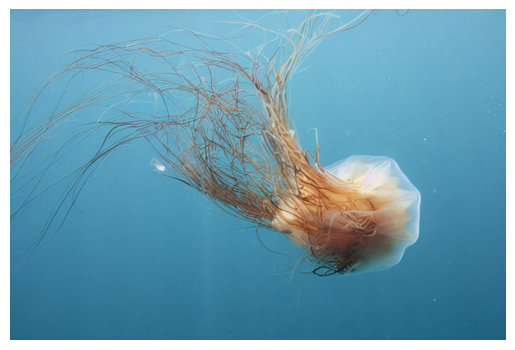

In [10]:
## Uncomment if you want to visualize the training data stored in latentDataset
## This will load the autoencoder which in unnecessary for training - only do it for educational purposes

from helpers.plotting_utils import plot_image
from helpers.pre_trained_autoencoder import encode, decode 
autoencoder = load_autoencoder(half_precision = True)

index = torch.randint(len(train_latentDataset), (1,))
plot_image(decode(autoencoder = autoencoder, z = train_loader.dataset.raw_latents[index]))



In [17]:
## Training hyperparameters

device = "cuda" if torch.cuda.is_available() else "cpu"
autoencoder = load_autoencoder(half_precision = True)

## Diffusion hyperparameters
num_epochs = 501       # Number of training epochs
total_timesteps = 1000   # Number of diffusion timesteps
learning_rate = 1e-2     # Learning rate
beta_t = cosine_beta_schedule(total_timesteps) # Variance Schedule, cosine or linear
cfg_dropout = 0.25       # Dropout for classifier free guidance
ema_decay = 0.995        # EMA decay
mixed_precision = True   # Mixed precision 

## Checkpoint
log_every = 5 # epochs
checkpoint_every = 100 # epochs

## Dataloader augmentation refreshing
refresh_dataloader = True
refresh_dataloader_every = 10 # epochs
refresh_number = 200 # images (must be less than the total number of images in the dataset)

# Create the Unet model
model = ConditionalUNet(dim = 128, dim_mults = (1,2,), beta_t = beta_t, timesteps = total_timesteps).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = flat_then_decay_w_warmup(optimizer = optimizer, num_epochs = num_epochs, flat_until = 0.4, warmup_steps = 100)
scaler = GradScaler()

## Load the training images
train_imageDataset = load_imageDataset()
print(f"Loaded {len(train_imageDataset)} train_images.")


epoch_start, ema_params, losses_total, train_loader = read_checkpoint(model = model, optimizer = optimizer, scaler = scaler, scheduler = scheduler)
print(f"Resuming at epoch: {epoch_start}") 


/tmp/ipykernel_502250/122446569.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Loaded 2472 train_images.
Model state_dict loaded
Optimizer state_dict loaded
Scheduler state_dict loaded
Gradient scaler state_dict loaded
Loaded train_loader
Model number of parameters: 11762604
Resuming at epoch: 499


In [18]:
# Training Loop

model.train()
clean()
for epoch in tqdm(range(epoch_start+1, num_epochs)):
    
    train_losses = []
    for i, (batch_conditions, batch_targets, batch_classes) in enumerate(train_loader):

        batch_conditions = batch_conditions.half().to(device)
        batch_targets = batch_targets.half().to(device)
        #batch_classes = batch_classes.to(device)
        #print(batch_conditions.shape)
        #print(batch_conditions.dtype)
        
        e = torch.randn_like(batch_targets)
        t = sample_t(bad_data = True, TOTAL_TIMESTEPS = total_timesteps, batch_targets = batch_targets, batch_classes = batch_classes)
        x_t, v_t = forward_sample(x_0 = batch_targets, t=t, e=e, alphas_cumprod = model.alphas_cumprod) # Calculates velocity

        # set to null token for unconditional model
        rand_ind = torch.randperm(batch_conditions.shape[0])[:int(cfg_dropout * batch_conditions.shape[0])]
        batch_conditions[rand_ind] = model.class_tokens.to(dtype = batch_conditions.dtype)

        optimizer.zero_grad(set_to_none=True)

        if mixed_precision:
            with torch.cuda.amp.autocast():
                v_pred = model(x_t, batch_conditions, t)
                loss = torch.nn.functional.mse_loss(v_t, v_pred)
             
            if torch.isnan(loss): # If crash   
                optimizer.zero_grad(set_to_none=True)
                continue
                
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

        else:
            v_pred = model(x_t, batch_conditions, t)
            loss = torch.nn.functional.mse_loss(v_t, v_pred)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        if epoch > 5:
            update_ema(model = model, ema_params = ema_params, ema_decay = ema_decay)
        train_losses.append(loss.item())  # Store the original loss

    if scheduler:
        scheduler.step()
    losses_total.append(np.mean(train_losses))
    
    ## User Logs
    if (epoch+1) % log_every == 0:
        print(f"Epoch: {epoch+1} Train Loss: {np.mean(train_losses)}")
        print_training_logs(epoch = epoch, losses_total = losses_total, optimizer = optimizer)

    ## Write Checkpoint
    if (epoch+1) % checkpoint_every == 0 and epoch != 0:
        ## Need to update the name of saved model
        write_checkpoint(epoch = epoch, model = model, optimizer = optimizer, scaler = scaler, ema_params = ema_params, losses_total = losses_total, train_loader = train_loader,
                   scheduler = scheduler)

    if refresh_dataloader and (epoch + 1) % refresh_dataloader_every == 0 and epoch != 0:
        train_loader =  update_dataloader(train_loader = train_loader, train_imageDataset = train_imageDataset, autoencoder = autoencoder, N = refresh_number)
        

    if (epoch+1) % 100 == 0 and epoch != 0:
        #update_dataloader(train_loader)
        #train_loader = renew_dataloader()
        clean()

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_502250/4160529651.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 1/1 [00:24<00:00, 24.72s/it]


In [ ]:
## Optional - save the model at the end of training if not a multiple of checkpoint_every
write_checkpoint(epoch = epoch, model = model, optimizer = optimizer, scaler = scaler, ema_params = ema_params, losses_total = losses_total, train_loader = train_loader,
                   scheduler = scheduler)

Model saved, epoch: 290
